# Spam Filter SVM

In [66]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from libsvm.svmutil import *
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Part A: Spambase E-Mail Dataset

We fetch the data, normalize it, and split it into training data and test data.

In [49]:
spambase = fetch_ucirepo(id=94)

D3_X = spambase.data.features
D3_y = spambase.data.targets

scaler = MinMaxScaler()
D3_X = scaler.fit_transform(D3_X)

D3_X_train, D3_X_test, D3_y_train, D3_y_test = train_test_split(D3_X, D3_y, test_size=0.3, random_state=420)

We implement the function `to_LIBSVM` to convert the data to the specified libsvm format.

In [50]:
def to_LIBSVM(X, y, file_name):
    with open(file_name, 'w') as f:
        for i, row in enumerate(X):
            label = 1 if y.iloc[i, 0] == 1 else -1
            features = ' '.join(f'{j + 1}:{v}' for j, v in enumerate(row))
            f.write(f'{label} {features}\n')

In [51]:
PATH_TRAIN = 'data/spambase/libsvm_train.txt'
PATH_TEST = 'data/spambase/libsvm_test.txt'

to_LIBSVM(D3_X_train, D3_y_train, PATH_TRAIN)
to_LIBSVM(D3_X_test, D3_y_test, PATH_TEST)

Accuracy = 60.7531% (839/1381) (classification)
Accuracy = 85.2281% (1177/1381) (classification)
Accuracy = 89.9348% (1242/1381) (classification)
Accuracy = 92.1072% (1272/1381) (classification)
Accuracy = 92.9761% (1284/1381) (classification)
Accuracy = 92.9761% (1284/1381) (classification)


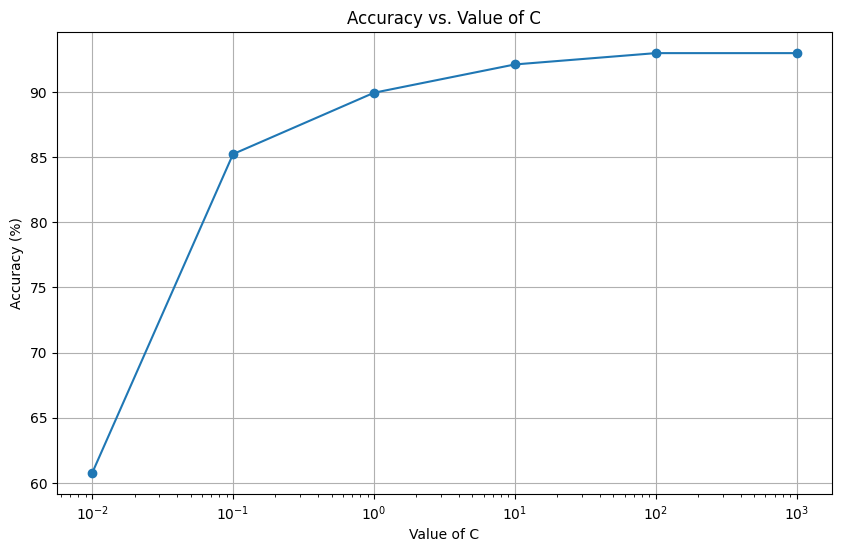

In [59]:
def train_predict_optimize():
    y_train, x_train = svm_read_problem(PATH_TRAIN)
    y_test, x_test = svm_read_problem(PATH_TEST)

    Cs = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    accs = []

    for C in Cs:
        model = svm_train(y_train, x_train, f'-t 0 -c {C}')
        _, p_acc, _ = svm_predict(y_test, x_test, model)

        accs.append(p_acc[0])

    plt.figure(figsize=(10, 6))
    plt.plot(Cs, accs, marker='o')
    plt.title('Accuracy vs. Value of C')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Value of C')
    plt.xscale('log')
    plt.grid(True)
    plt.show()


train_predict_optimize()

The accuracy increases with the value of $C$, showing a monotonically non-decreasing trend. Accuracy plateaus at ~92.3%. This aligns with the description of the dataset in the archive where the typical performance is stated as "around ~7% misclassification error" (https://archive.ics.uci.edu/dataset/94/spambase).

## Part B: SMS Spam Collection Dataset

We use `TfidfVectorizer` from sklearn's feature selection to convert the dataset to features. To avoid stop words (e.g., “this,” “the,” “is,” etc.), we use the built-in stop word removal.

In [53]:
D2_PATH = 'data/sms+spam+collection/SMSSpamCollection'


def to_texts():
    labels = []
    texts = []

    with open(D2_PATH, 'r') as f:
        for l in f:
            components = l.split()
            labels.append(1 if components[0] == 'ham' else -1)

            texts.append(' '.join(components[1:]))

    return labels, texts


labels, texts = to_texts()

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(texts)

X_tfidf.shape

(5574, 8483)

TfidfVectorizer does not use one-hot-encoding, but still each datapoint is represented by a vector of length 8483 and mostly sparse values. So we reduce the dimensionality with `TruncatedSVD` form sklearn.decomposition.

In [54]:
svd = TruncatedSVD(n_components=300, random_state=69)
X_tfidf_reduced = svd.fit_transform(X_tfidf)
X_tfidf_reduced.shape

(5574, 300)

We normalize the data and split it in training and test data.

In [55]:
scaler = MinMaxScaler()
D2_X = scaler.fit_transform(X_tfidf_reduced)
D2_y = labels

D2_X_train, D2_X_test, D2_y_train, D2_y_test = train_test_split(D2_X, D2_y, test_size=0.3, random_state=420)

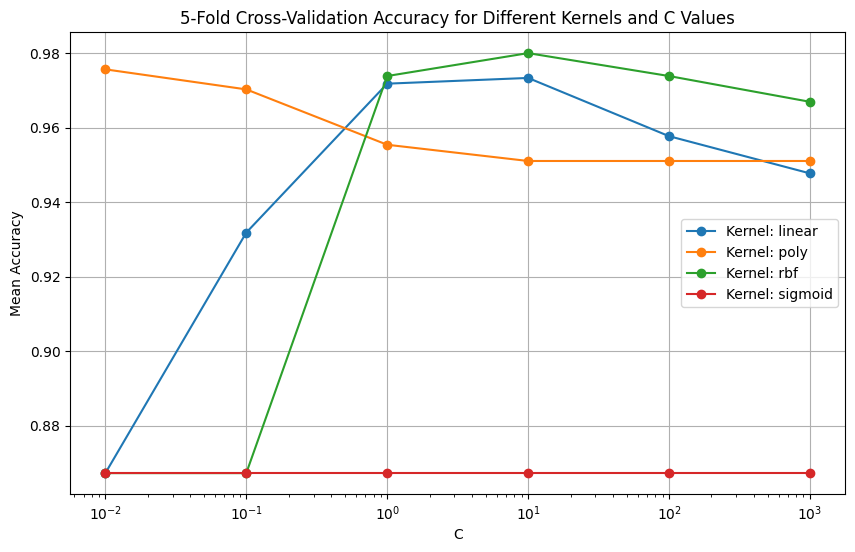

In [57]:
def evaluate_SVC():
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    Cs = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    results = []

    for k in kernels:
        for C in Cs:
            model = SVC(kernel=k, C=C)
            scores = cross_val_score(model, D2_X_train, D2_y_train, cv=5, scoring='accuracy')

            mean = scores.mean()

            results.append({'Kernel': k, 'C': C, 'Mean Accuracy': mean})

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    for k in kernels:
        subset = results_df[results_df['Kernel'] == k]
        plt.plot(subset['C'], subset['Mean Accuracy'], marker='o', label=f'Kernel: {k}')

    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Mean Accuracy')
    plt.title('Mean Accuracy vs. Value of C for 5-Fold Cross-Validation')
    plt.legend()
    plt.grid(True)
    plt.show()


evaluate_SVC()

The figure show that the Radial Basis Function, which is scikit's standard) kernel is the best choice when $C \ge 1$, consistently delivering the highest accuracy. The RBF kernel with $C = 10$ achieves the overall best performance. For smaller values of C, the polynomial kernel performs the best, though its accuracy decreases as C increases. The linear kernel performs well for moderate to high C values but doesn’t quite match the RBF kernel’s performance. The sigmoid kernel performs the worst overall, showing no improvement regardless of the C value.

# Comparison with Another Model

We compare the C-Support Vector Classification (SVC) from Task B to the K-Nearest Neighbors, both from Sklearn. We optimize neighbors and metrics (haversine distance only available in 2 dimensions).


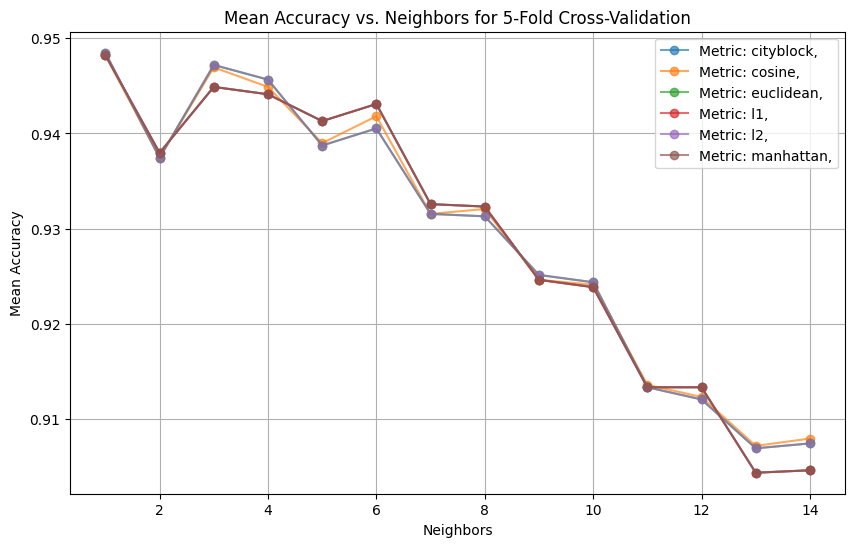

In [65]:
def evaluate_KNN():
    neighbors = range(1, 15)
    metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

    results = []

    for n in neighbors:
        for m in metrics:
            model = KNeighborsClassifier(n_neighbors=n, metric=m)

            scores = cross_val_score(model, D2_X_train, D2_y_train, cv=5, scoring='accuracy')

            mean = scores.mean()

            results.append({'Neighbors': n, 'Metric': m, 'Mean Accuracy': mean})

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    for m in metrics:
        subset = results_df[results_df['Metric'] == m]
        plt.plot(subset['Neighbors'], subset['Mean Accuracy'], marker='o', label=f'Metric: {m},', alpha=0.67)

    plt.xlabel('Neighbors')
    plt.ylabel('Mean Accuracy')
    plt.title('Mean Accuracy vs. Neighbors for 5-Fold Cross-Validation')
    plt.legend()
    plt.grid(True)
    plt.show()


evaluate_KNN()

The figure shows that as the number of neighbors increases, the accuracy decreases, which suggests **overfitting** for smaller values of n and a loss of model flexibility. The performance of different distance metrics is very similar, indicating that the choice of metric has minimal impact on accuracy for this dataset. Additionally, odd values for n generally perform better than even values, likely because odd numbers help avoid ties in voting during classification.

Finally, we measure the accuracy of SVC and KNN on the Test data and compare the results.

Best SVC Test Accuracy (RBF kernel, C=10): 0.9845
Best KNN Test Accuracy (1 neighbor, Minkowski): 0.9617


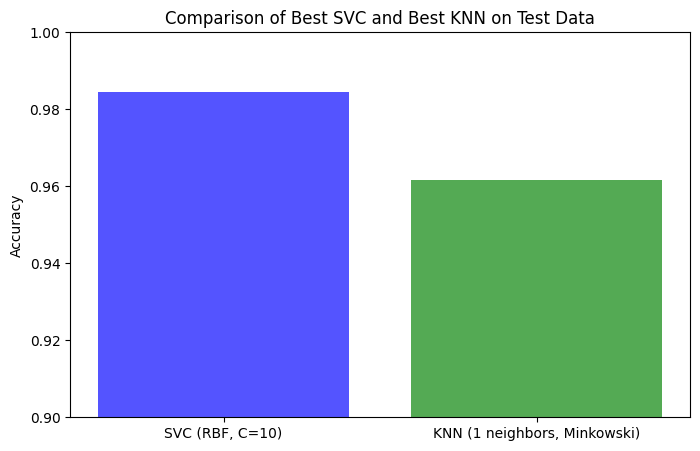

In [74]:
best_svc = SVC(kernel='rbf', C=10)
best_svc.fit(D2_X_train, D2_y_train)
svc_predictions = best_svc.predict(D2_X_test)
svc_accuracy = accuracy_score(D2_y_test, svc_predictions)

best_knn = KNeighborsClassifier(n_neighbors=1)
best_knn.fit(D2_X_train, D2_y_train)
knn_predictions = best_knn.predict(D2_X_test)
knn_accuracy = accuracy_score(D2_y_test, knn_predictions)

print(f"Best SVC Test Accuracy (RBF kernel, C=10): {svc_accuracy:.4f}")
print(f"Best KNN Test Accuracy (1 neighbor, Minkowski): {knn_accuracy:.4f}")

models = ['SVC (RBF, C=10)', 'KNN (1 neighbors, Minkowski)']
accuracies = [svc_accuracy, knn_accuracy]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green'], alpha=0.67)
plt.ylabel('Accuracy')
plt.title('Comparison of Best SVC and Best KNN on Test Data')
plt.ylim(0.9, 1)
plt.show()

The results show that SVC with the RBF kernel and C = 10 achieves the highest test accuracy of 98.45%, outperforming the KNN model, which achieves 96.17% with 1 neighbor and the Minkowski distance. The KNN model's use of just 1 neighbor likely leads to overfitting, as it makes predictions based solely on the closest data point. In comparison, the SVC model captures the broader patterns in the data, resulting in better generalization and overall higher accuracy.